<class 'pandas.core.series.Series'>
2018-02-01 09:06:01
2018-02-01 09:07:02   -9.9
2018-02-01 09:10:01   -9.9
2018-02-01 09:13:01   -9.9
2018-02-01 09:37:01   -9.9
2018-02-01 09:38:02   -9.9
Name: -9.9, dtype: float64


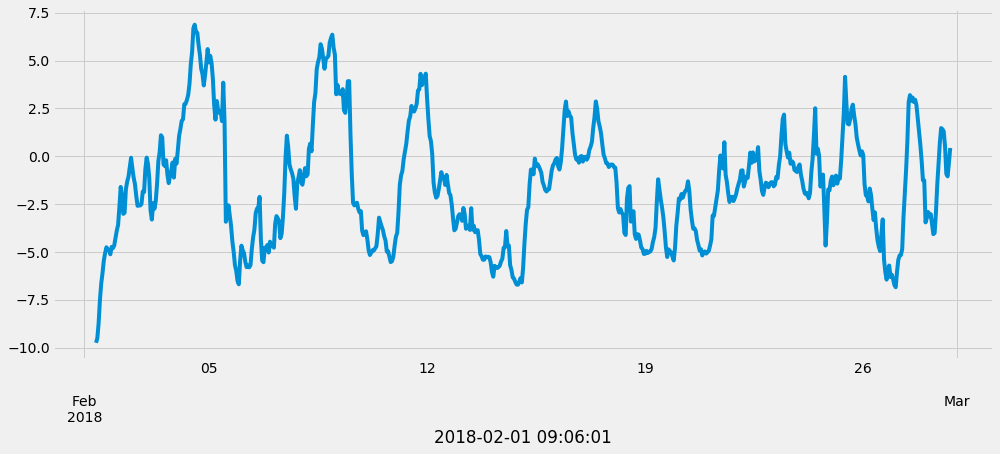

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

data = pd.read_csv('../data/temperature.csv', ',', header=0, parse_dates=[0], index_col=0, squeeze=True)
print(type(data))
print(data.head())
y = data.replace(to_replace=-1000, value=np.nan)
y = y.fillna(y.bfill())

y = y.resample('H').mean()

y.plot(figsize=(15,6))
plt.show()



In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets 
pdq = list(itertools.product(p, d, q)) 

# Generation all different combination of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d , q))]

# print('Example of parameters combinations for Seasonal ARIMA...')
# print('SARIMAX {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX {} x {}'.format(pdq[2], seasonal_pdq[4]))

warnings.filterwarnings("ignore") # specify to ignore warning message

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param,
                                              param_seasonal,
                                              results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:3280.5550132284407
ARIMA(0, 0, 0)x(0, 0, 2, 24) - AIC:3174.6587164336847
ARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:3138.8554419469074
ARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:3007.374964870869
ARIMA(0, 0, 0)x(0, 2, 1, 24) - AIC:3431.948789146983
ARIMA(0, 0, 0)x(0, 2, 2, 24) - AIC:3056.6782044583993
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:3286.180528597213
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:3281.6030174421403
ARIMA(0, 0, 0)x(1, 0, 2, 24) - AIC:3175.9320087006618
ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:3412.149322167861
ARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:3130.315510763298
ARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:2982.2242541667247
ARIMA(0, 0, 0)x(1, 2, 0, 24) - AIC:3732.5407130368912
ARIMA(0, 0, 0)x(1, 2, 1, 24) - AIC:3375.457051294455
ARIMA(0, 0, 0)x(1, 2, 2, 24) - AIC:3268.6280255594634
ARIMA(0, 0, 0)x(2, 0, 0, 24) - AIC:3177.3084399929726
ARIMA(0, 0, 0)x(2, 0, 1, 24) - AIC:3178.369836616843
ARIMA(0, 0, 0)x(2, 0, 2, 24) - AIC:3054.080818668557
ARIMA(0, 0, 0)x(2, 1, 0, 24) - AIC:3

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1944      0.142     -1.366      0.172      -0.473       0.084
ma.L1          0.4307      0.135      3.188      0.001       0.166       0.695
ar.S.L24      -0.1472      0.043     -3.444      0.001      -0.231      -0.063
ma.S.L24      -1.1431      0.034    -33.557      0.000      -1.210      -1.076
sigma2         0.3097      0.021     15.078      0.000       0.269       0.350


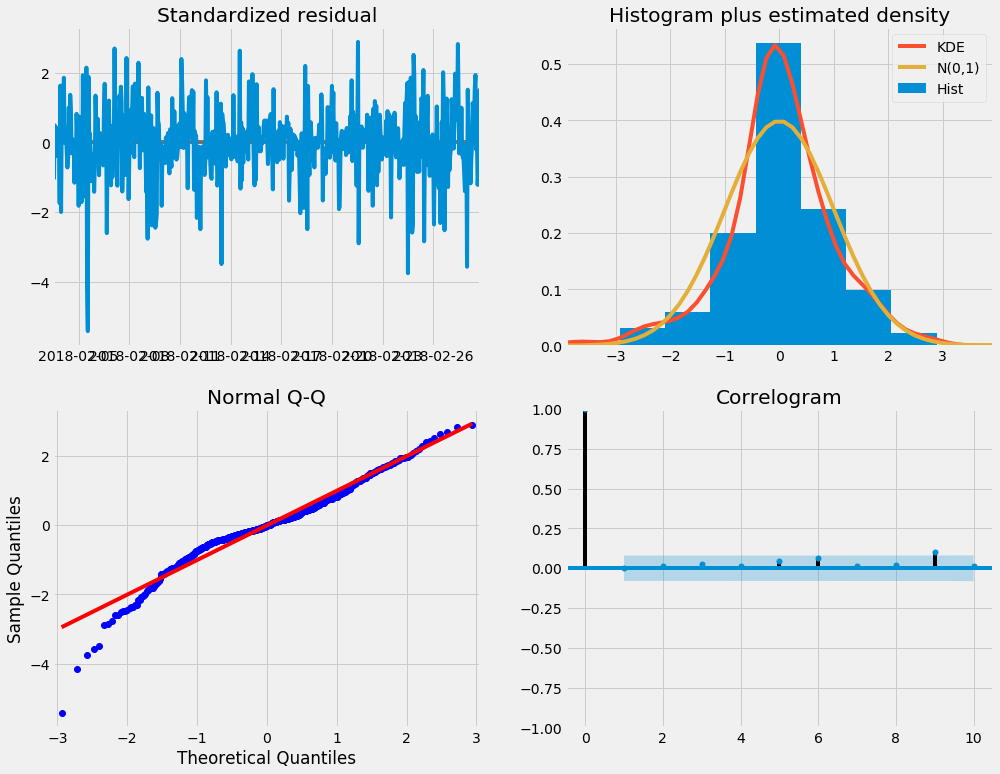

In [20]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False                            
                               )

results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15,12))
plt.show()



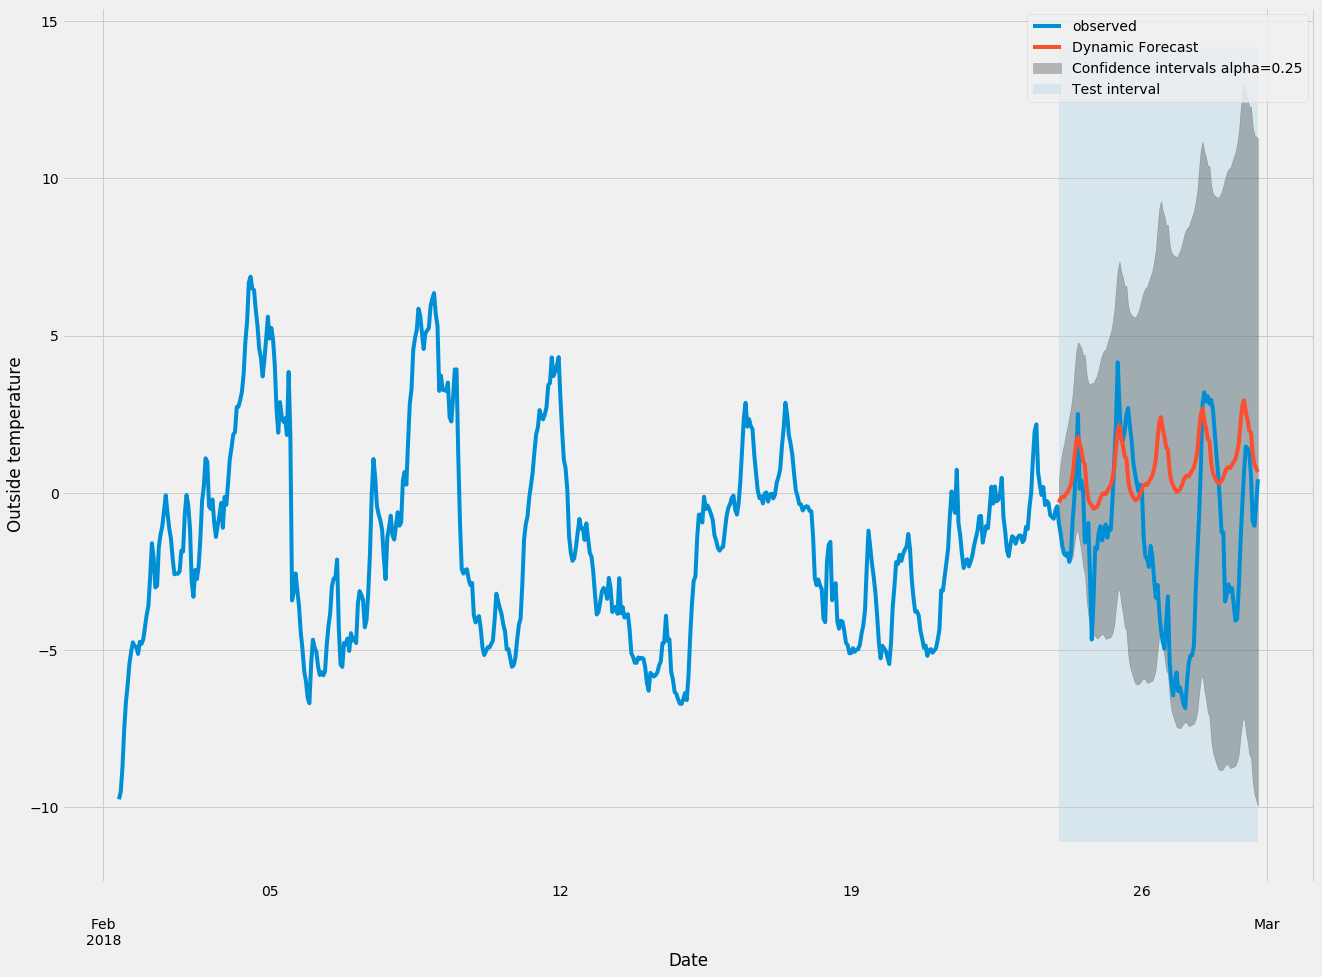

In [21]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-02-24 00:00:00'),
                                      dynamic=True,
                                      full_results=True) # Start predict time
p = 0.75

pred_dynamic_ci = pred_dynamic.conf_int(alpha=1-p) # confidence intervals

ax = y['2018-02-01 00:00:00':].plot(label='observed', figsize=(20,15)) #start learn sequence plot time 
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = 1-p, label='Confidence intervals alpha={}'.format(1-p))

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-02-24 00:00:00'), y.index[-1],
                 alpha=0.1, zorder=-1, label='Test interval') # Start predict time

ax.set_xlabel('Date')
ax.set_ylabel('Outside temperature')

plt.legend()
plt.show()